In [77]:
import os
import numpy as np
import glob
import rmgpy.chemkin
import rmgpy.species
import rmgpy.reaction
import rmgpy.data.kinetics

import autotst.species
import autotst.reaction
import ase.calculators.lj
import autotst.conformer.systematic

import ase.atoms
import ase.io.gaussian


import sys
DFT_DIR = '/home/moon/autoscience/reaction_calculator/dft'
sys.path.append(DFT_DIR)
import thermokinetic_fun


from ase.visualize import view

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
family = 'Disproportionation'

In [4]:
reaction_index = 1766
reaction_smiles = thermokinetic_fun.reaction_index2smiles(reaction_index)

In [7]:
reaction = autotst.reaction.Reaction(label=reaction_smiles)
reaction.ts['forward'][0].get_molecules()

reaction.py:171 load_databases INFO Loading RMG database from '/home/moon/rmg/RMG-database/input'
transport.py:294 load_groups INFO Loading transport group database from /home/moon/rmg/RMG-database/input/transport/groups...
statmech.py:541 load_libraries INFO Loading frequencies library from halogens_G4.py in /home/moon/rmg/RMG-database/input/statmech/libraries...
statmech.py:555 load_groups INFO Loading frequencies group database from /home/moon/rmg/RMG-database/input/statmech/groups...
thermo.py:952 load_libraries INFO Loading thermodynamics library from primaryThermoLibrary.py in /home/moon/rmg/RMG-database/input/thermo/libraries...
thermo.py:952 load_libraries INFO Loading thermodynamics library from thermo_DFT_CCSDTF12_BAC.py in /home/moon/rmg/RMG-database/input/thermo/libraries...
thermo.py:952 load_libraries INFO Loading thermodynamics library from CBS_QB3_1dHR.py in /home/moon/rmg/RMG-database/input/thermo/libraries...
thermo.py:979 load_groups INFO Loading thermodynamics group

(<rdkit.Chem.rdchem.Mol at 0x7effbecd2d50>,
 Atoms(symbols='O2C6H14', pbc=False))

In [14]:
# confirm we're working with Disproportionation, otherwise this won't work
assert reaction.reaction_family == family

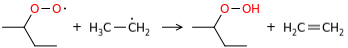

In [21]:
reaction.rmg_reaction

In [22]:
# load the constituent species
r0 = reaction.rmg_reaction.reactants[0]
r1 = reaction.rmg_reaction.reactants[1]

In [27]:
r0_index = thermokinetic_fun.species_smiles2index(r0.smiles)
r1_index = thermokinetic_fun.species_smiles2index(r1.smiles)

## Get the labels on the reactants

In [38]:
# load the Disproportionation family
# load the thermo database,
# this is minimal for better speed
thermo_libs = [
    'BurkeH2O2',
    'primaryThermoLibrary',
    'FFCM1(-)',
    'CurranPentane',
    'Klippenstein_Glarborg2016',
    'thermo_DFT_CCSDTF12_BAC',
    'DFT_QCI_thermo',
    'CBS_QB3_1dHR',
]

thermo_library_path = os.path.join(rmgpy.settings['database.directory'], 'thermo')
thermo_database = rmgpy.data.thermo.ThermoDatabase()
thermo_database.load(
    thermo_library_path,
    libraries=thermo_libs
)

kinetic_libs = [
    'FFCM1(-)',
    'CurranPentane',
    'combustion_core/version5',
    'Klippenstein_Glarborg2016',
    'BurkeH2O2inArHe',
    'BurkeH2O2inN2',
]

# load the families
ref_library_path = os.path.join(rmgpy.settings['database.directory'], 'kinetics')
kinetics_database = rmgpy.data.kinetics.KineticsDatabase()
kinetics_database.load(
    ref_library_path,
    libraries=kinetic_libs,
    families=[family]
)

# load the entire database
ref_db = rmgpy.data.rmg.RMGDatabase()
ref_db.kinetics = kinetics_database
ref_db.thermo = thermo_database



thermo.py:952 load_libraries INFO Loading thermodynamics library from BurkeH2O2.py in /home/moon/rmg/RMG-database/input/thermo/libraries...
thermo.py:952 load_libraries INFO Loading thermodynamics library from primaryThermoLibrary.py in /home/moon/rmg/RMG-database/input/thermo/libraries...
thermo.py:952 load_libraries INFO Loading thermodynamics library from FFCM1(-).py in /home/moon/rmg/RMG-database/input/thermo/libraries...
thermo.py:952 load_libraries INFO Loading thermodynamics library from CurranPentane.py in /home/moon/rmg/RMG-database/input/thermo/libraries...
thermo.py:952 load_libraries INFO Loading thermodynamics library from Klippenstein_Glarborg2016.py in /home/moon/rmg/RMG-database/input/thermo/libraries...
thermo.py:952 load_libraries INFO Loading thermodynamics library from thermo_DFT_CCSDTF12_BAC.py in /home/moon/rmg/RMG-database/input/thermo/libraries...
thermo.py:952 load_libraries INFO Loading thermodynamics library from DFT_QCI_thermo.py in /home/moon/rmg/RMG-databa

In [39]:
templates = ref_db.kinetics.families[family].generate_reactions([r0.molecule[0], r1.molecule[0]], relabel_atoms=True)

In [45]:
labeled_r, labeled_p = ref_db.kinetics.families[family].get_labeled_reactants_and_products(
    [r0.molecule[0], r1.molecule[0]],
    [reaction.rmg_reaction.products[0].molecule[0], reaction.rmg_reaction.products[1].molecule[0]],
    relabel_atoms=True
)


In [47]:
# # rename to make sure molecule 0 has labels *2,*3,*4 and molecule 1 has *1
# if not labeled_r[0].is_isomorphic(r0.molecule[0]):
#     print('wrong order, rearranging')
#     temp0 = labeled_r[0]
#     temp1 = labeled_r[1]
#     labeled_r[0] = temp1
#     labeled_r[1] = temp0


## rename to make sure molecule 0 has labels *2,*3,*4 and molecule 1 has *1

In [68]:
try:
    labeled_r[1].get_labeled_atoms('*1')
except ValueError:
    print('wrong order, rearranging')
    temp0 = labeled_r[0]
    temp1 = labeled_r[1]
    labeled_r[0] = temp1
    labeled_r[1] = temp0

    temp_index0 = r0_index
    temp_index1 = r1_index
    r0_index = temp_index1
    r1_index = temp_index0
    
    # TODO also switch out the rmg species objects...

wrong order, rearranging


In [94]:
# load the logfiles and get geometries
r0_log = glob.glob(os.path.join(DFT_DIR, 'thermo', f'species_{r0_index:04}', 'arkane', 'conformer*.log'))[0]
r1_log = glob.glob(os.path.join(DFT_DIR, 'thermo', f'species_{r1_index:04}', 'arkane', 'conformer*.log'))[0]
with open(r0_log, 'r') as f:
    r0_atoms = ase.io.gaussian.read_gaussian_out(f)
with open(r1_log, 'r') as f:
    r1_atoms = ase.io.gaussian.read_gaussian_out(f)

In [70]:
atom_1_index = labeled_r[1].get_labeled_atoms('*1')[0].sorting_label
atom_2_index = labeled_r[0].get_labeled_atoms('*2')[0].sorting_label
atom_3_index = labeled_r[0].get_labeled_atoms('*3')[0].sorting_label
atom_4_index = labeled_r[0].get_labeled_atoms('*4')[0].sorting_label

In [79]:
type(r0_atoms)

ase.atoms.Atoms

In [72]:
print('*1\t', atom_1_index, r1_atoms[atom_1_index])
print('*2\t', atom_2_index, r0_atoms[atom_2_index])
print('*4\t', atom_4_index, r0_atoms[atom_4_index])

*1	 1 Atom('O', [1.733789, -1.280163, 0.138661], index=1)
*2	 0 Atom('C', [0.692251, -6e-06, -0.000607], index=0)
*4	 2 Atom('H', [1.101916, 0.883299, -0.491118], index=2)


In [80]:
reaction_core = ase.atoms.Atoms([r1_atoms[atom_1_index], r0_atoms[atom_2_index], r0_atoms[atom_4_index]])

In [86]:
# keep molecule 0 in place
my_ts = r0_atoms

In [87]:
view(my_ts, viewer='x3d')

## translate molecule 1 to be X Angstroms away from atom 4 in the line of the 2-4 bond

In [145]:
# make a ray to extend from labeled atom *2 to *4
# reload geometry fresh each time
with open(r0_log, 'r') as f:
    r0_atoms = ase.io.gaussian.read_gaussian_out(f)
with open(r1_log, 'r') as f:
    r1_atoms = ase.io.gaussian.read_gaussian_out(f)


ray = r0_atoms[atom_4_index].position - r0_atoms[atom_2_index].position
ray /= np.linalg.norm(ray)  # normalize

# move the Hydrogen (*4) to be d23 away from the other atom (*2)
# d23 represents labels *2 - *4 from Disproportionation
H_distance_2_4 = reaction.ts['forward'][0].distance_data.distances['d23']
H_position = r0_atoms[atom_2_index].position + H_distance_2_4 * ray
r0_atoms[atom_4_index].position = H_position

# translate molecule 1's (*1) to be d12 from the H(*4) on molecule 0
d14 = reaction.ts['forward'][0].distance_data.distances['d12']
a1_new_position = H_position + d14 * ray
translation = a1_new_position - r1_atoms[atom_1_index].position
r1_atoms.translate(translation)


# rotate the entire molecule 360 degrees to get lowest energy config?

# use law of cosines to get angle of rotation required to match distance data
a = H_distance_2_4
b = reaction.ts['forward'][0].distance_data.distances['d13']
c = d14
assert b > a
assert b > c
angle_rad = np.arccos((c * c - a * a - b * b) / (-2 * a * b))
angle_deg = angle_rad * 180 / np.pi


# rotate the entire molecule ~5 degrees
# vector is arbitrary, but we can try experimenting with this to see what gets best results
r1_atoms.rotate(angle_deg, v='x', center=r0_atoms[atom_4_index].position)

In [140]:
angle_deg

4.269599814939051

In [146]:
total = r0_atoms + r1_atoms

In [147]:
ase.io.write('translate_rotate.xyz', total)

In [127]:
reaction.ts['forward'][0].distance_data.distances

{'d12': 1.58633, 'd13': 2.64511, 'd23': 1.06371}

In [112]:
view(r0_atoms + r1_atoms, viewer='x3d')

In [57]:
atom_2_index

0

In [119]:
reaction.ts['forward'][0].distance_data

DistanceData(distances={'d12': 1.586330,'d13': 2.645110,'d23': 1.063710,}, uncertainties={'d12': 0.000000,'d13': 0.000000,'d23': 0.000000,})